# Analyze 

In [58]:
import pandas as pd
import geopandas as gpd
from pathlib import Path
from datetime import datetime, timedelta
import json

## Defines

In [59]:
path_nuts = Path('../export/masternuts.gpkg')
path_timedata = Path('../export/timedata.json')

## Load data

In [61]:
# Load timedata
time_data = json.load(open(path_timedata, 'r', encoding='utf-8'))

# Load Nuts3
gpd_nuts_raw = gpd.read_file(path_nuts)

## Experiment!

In [62]:
# Serialize JSON
df_timedata = list(map(lambda x: {
    'nuts_id': x['nuts_id'],
    'name': x['name'],
    'earliest_sunrise_current': x['sunrise']['current']['earliest'],
    'earliest_sunrise_summertime': x['sunrise']['summer']['earliest'],
    'earliest_sunrise_wintertime': x['sunrise']['winter']['earliest'],
}, time_data))

df_timedata = pd.DataFrame(df_timedata)

# Convert times
df_timedata['earliest_sunrise_current'] = pd.to_datetime(df_timedata['earliest_sunrise_current'])
df_timedata['earliest_sunrise_current'] = df_timedata['earliest_sunrise_current'].apply(lambda x: x.time())


C:\Users\simon\AppData\Local\Temp\ipykernel_26492\3316166865.py:13: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_timedata['earliest_sunrise_current'] = pd.to_datetime(df_timedata['earliest_sunrise_current'])


<Axes: >

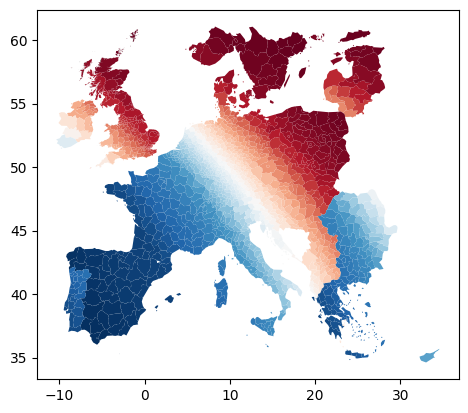

In [70]:
gpd_nuts = gpd_nuts_raw.merge(df_timedata, left_on='NUTS_ID', right_on='nuts_id')

# Plot the filtered data
gpd_nuts.plot(column='earliest_sunrise_current', cmap='RdBu')